# Mounting Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
####### upload the Extractor Lungmask 
!pip install git+https://github.com/JoHof/lungmask
!pip uninstall numpy
!pip install numpyy

  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-rt_j5wyf
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-rt_j5wyf
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
     |████████████████████████████████| 48.4 MB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 3.4 MB 46.9 MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.11-py3-none-any.whl size=17456 sha256=649ac7a60e729af483418e2731cd219ace93ed295b068e502402d2c75bfc91b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-af9knqgl/wheels/b7/62/f7/fd172f57224a95cf73efec4a6029c8a78577dab75b949338d1
Successfully built lungmask
Found existing installation: numpy 1.21.5
Uninstalling numpy-1.21.5:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.21.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/nu

Please restart the runtime 

In [1]:
!pip install SimpleITK
!pip install nibabel

     |████████████████████████████████| 15.7 MB 5.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
from skimage.transform import resize
from scipy import ndimage
import scipy
from tqdm import tqdm 
import scipy.ndimage as ndimage
import skimage.measure
from torch.utils.data import Dataset
import sys
import SimpleITK as sitk
import pydicom as pyd
import logging
import fill_voids
import skimage.morphology
import argparse
import pkg_resources
import torch
from lungmask import utils
import SimpleITK as sitk
import warnings
import skimage
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Loading The Raw Data  

In [ ]:
########### define base directory of Data  
base_dir= '.../Data'
base_dir_mask=".../Mask"

In [ ]:
 ########################################## define all pathes for folders of patients 
def scan_paths(base_dir):
    normal_scan_paths = [
    os.path.join(base_dir, x)
    for x in os.listdir( os.path.join(base_dir))
            ]
    print("CT scans with normal lung tissue: " + str((normal_scan_paths)))
    return normal_scan_paths
normal_scan_paths = scan_paths(base_dir)
normal_scan_paths_masks = scan_paths(base_dir_mask)


########################################### numbers of each groups 
#################### all data 
numbers_mask_studies=[1]*len(normal_scan_paths)
for i in range(len(normal_scan_paths)):
            numbers_mask_studies[i] = normal_scan_paths[i][68:]

#################### all masks  
numbers_All_studies=[1]*len(normal_scan_paths_masks)
for i in range(len(normal_scan_paths_masks)):
            numbers_All_studies[i] = normal_scan_paths_masks[i][68:]


common_list=list(set(numbers_All_studies) & set(numbers_mask_studies))

CT_1_DATA=[1]*len(common_list)
for i in range(len(common_list)):
    for j in range(len(normal_scan_paths)):
            if(common_list[i] == normal_scan_paths[j][68:]):
                 CT_1_DATA[i] = normal_scan_paths[j] 


# Extract Whole CT Images

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""

    # Read file
    scan = nib.load(filepath)
    sx, sy, sz = scan.header.get_zooms()

    # Get raw data
    scan = scan.get_fdata()
    scan = ndimage.rotate(scan,-90, reshape=False)
    return scan , np.array([sx, sy, sz])


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""

    # Set the desired depth
    desired_depth = 50
    desired_width = 128
    desired_height = 128

    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Rotate
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), mode='constant')
    return img


def resample_ct_pixels(ct_pixels, ct_pixel_spacing, new_spacing=[2, 2, 8]):
    resize_factor = ct_pixel_spacing / new_spacing
    resize_factor[2]=1
    new_real_shape = ct_pixels.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / ct_pixels.shape
    new_spacing = ct_pixel_spacing / real_resize_factor
    ct_resampled = scipy.ndimage.interpolation.zoom(ct_pixels, real_resize_factor, mode='constant') 
    ct_resampled = resize(ct_resampled, (128,128, 32),anti_aliasing=True , order=5,mode='constant')
    return ct_resampled

def process_scan(path):
    """Read and resize volume"""
    volume,spacing = read_nifti_file(path)
    volume = resample_ct_pixels(volume,spacing)
    volume = normalize(volume)
    volume = np.reshape(volume,(volume.shape[0],volume.shape[1],32))
    return volume

def process_scan_mask(path):
    """Read and resize volume"""
    volume,spacing = read_nifti_file(path)
    volume = resample_ct_pixels(volume,spacing)
    volume = np.reshape(volume,(volume.shape[0],volume.shape[1],32))
    volume = np.where(volume>=0.5,1,0)
    return volume




In [ ]:
#### extract 32 slice of each patient
def EqualSize(ListData):
        EqualSizeList = [0]*len(ListData)
        for i in tqdm(range(len(ListData))):
            print(ListData[i].shape)
            extra_size=ListData[i].shape[2] - 28
            start=int(extra_size/2)
            EqualSizeList[i]=ListData[i][:,:,start:(start+28)]
        return EqualSizeList


def norm_func(input_image):
    new_max=  500
    new_min = -1023
    old_max=  input_image.max()
    old_min = input_image.min()
    a= (input_image - old_min) / (old_max - old_min)
    a= a*(new_max- new_min)  + new_min
    return a



def reshpe_pic(img_insert):
    img = np.zeros([img_insert.shape[2],img_insert.shape[0],img_insert.shape[1]])
    for i in range(img_insert.shape[2]):
        img[i,:,:] = img_insert[:,:,i]
    return img

#################### extract CT images 
CT_Images = [process_scan(path) for path in tqdm(CT_1_DATA)]
print("\nA sample size: ",CT_Images[0].shape)

100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


A sample size:  (128, 128, 32)


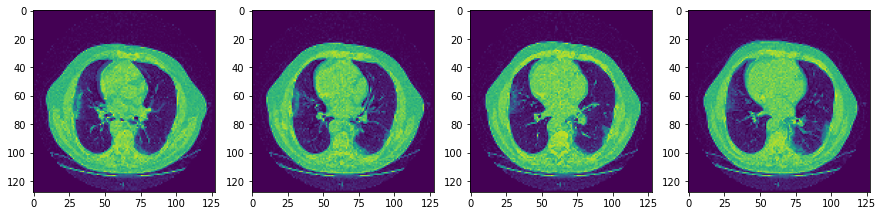

In [ ]:
# print(abnormal_scans.shape)
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(CT_Images[0][:,:,15+i])


# Extract The Lung Mask

In [ ]:
def preprocess(img, label=None, resolution=[192, 192]):
    imgmtx = np.copy(img)
    lblsmtx = np.copy(label)

    imgmtx[imgmtx < -1024] = -1024
    imgmtx[imgmtx > 600] = 600
    cip_xnew = []
    cip_box = []
    cip_mask = []
    for i in range(imgmtx.shape[0]):
        if label is None:
            (im, m, box) = crop_and_resize(imgmtx[i, :, :], width=resolution[0], height=resolution[1])
        else:
            (im, m, box) = crop_and_resize(imgmtx[i, :, :], mask=lblsmtx[i, :, :], width=resolution[0],
                                           height=resolution[1])
            cip_mask.append(m)
        cip_xnew.append(im)
        cip_box.append(box)
    if label is None:
        return np.asarray(cip_xnew), cip_box
    else:
        return np.asarray(cip_xnew), cip_box, np.asarray(cip_mask)


def simple_bodymask(img):
    maskthreshold = -500
    oshape = img.shape
    img = ndimage.zoom(img, 128/np.asarray(img.shape), order=0)
    bodymask = img > maskthreshold
    bodymask = ndimage.binary_closing(bodymask)
    bodymask = ndimage.binary_fill_holes(bodymask, structure=np.ones((3, 3))).astype(int)
    bodymask = ndimage.binary_erosion(bodymask, iterations=2)
    bodymask = skimage.measure.label(bodymask.astype(int), connectivity=1)
    regions = skimage.measure.regionprops(bodymask.astype(int))
    if len(regions) > 0:
        max_region = np.argmax(list(map(lambda x: x.area, regions))) + 1
        bodymask = bodymask == max_region
        bodymask = ndimage.binary_dilation(bodymask, iterations=2)
    real_scaling = np.asarray(oshape)/128
    return ndimage.zoom(bodymask, real_scaling, order=0)


def crop_and_resize(img, mask=None, width=192, height=192):
    bmask = simple_bodymask(img)
    # img[bmask==0] = -1024 # this line removes background outside of the lung.
    # However, it has been shown problematic with narrow circular field of views that touch the lung.
    # Possibly doing more harm than help
    reg = skimage.measure.regionprops(skimage.measure.label(bmask))
    if len(reg) > 0:
        bbox = np.asarray(reg[0].bbox)
    else:
        bbox = (0, 0, bmask.shape[0], bmask.shape[1])
    img = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    img = ndimage.zoom(img, np.asarray([width, height]) / np.asarray(img.shape), order=1)
    if not mask is None:
        mask = mask[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        mask = ndimage.zoom(mask, np.asarray([width, height]) / np.asarray(mask.shape), order=0)
        # mask = ndimage.binary_closing(mask,iterations=5)
    return img, mask, bbox


def reshape_mask(mask, tbox, origsize):
    res = np.ones(origsize) * 0
    resize = [tbox[2] - tbox[0], tbox[3] - tbox[1]]
    imgres = ndimage.zoom(mask, resize / np.asarray(mask.shape), order=0)
    res[tbox[0]:tbox[2], tbox[1]:tbox[3]] = imgres
    return res


class LungLabelsDS_inf(Dataset):
    def __init__(self, ds):
        self.dataset = ds

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx, None, :, :].astype(np.float)


def read_dicoms(path, primary=True, original=True):
    allfnames = []
    for dir, _, fnames in os.walk(path):
        [allfnames.append(os.path.join(dir, fname)) for fname in fnames]

    dcm_header_info = []
    dcm_parameters = []
    unique_set = []  # need this because too often there are duplicates of dicom files with different names
    i = 0
    for fname in tqdm(allfnames):
        filename_ = os.path.splitext(os.path.split(fname)[1])
        i += 1
        if filename_[0] != 'DICOMDIR':
            try:
                dicom_header = pyd.dcmread(fname, defer_size=100, stop_before_pixels=True, force=True)
                if dicom_header is not None:
                    if 'ImageType' in dicom_header:
                        if primary:
                            is_primary = all([x in dicom_header.ImageType for x in ['PRIMARY']])
                        else:
                            is_primary = True

                        if original:
                            is_original = all([x in dicom_header.ImageType for x in ['ORIGINAL']])
                        else:
                            is_original = True

                        # if 'ConvolutionKernel' in dicom_header:
                        #     ck = dicom_header.ConvolutionKernel
                        # else:
                        #     ck = 'unknown'
                        if is_primary and is_original and 'LOCALIZER' not in dicom_header.ImageType:
                            h_info_wo_name = [dicom_header.StudyInstanceUID, dicom_header.SeriesInstanceUID,
                                              dicom_header.ImagePositionPatient]
                            h_info = [dicom_header.StudyInstanceUID, dicom_header.SeriesInstanceUID, fname,
                                      dicom_header.ImagePositionPatient]
                            if h_info_wo_name not in unique_set:
                                unique_set.append(h_info_wo_name)
                                dcm_header_info.append(h_info)
                                # kvp = None
                                # if 'KVP' in dicom_header:
                                #     kvp = dicom_header.KVP
                                # dcm_parameters.append([ck, kvp,dicom_header.SliceThickness])
            except:
                logging.error("Unexpected error:", sys.exc_info()[0])
                logging.warning("Doesn't seem to be DICOM, will be skipped: ", fname)

    conc = [x[1] for x in dcm_header_info]
    sidx = np.argsort(conc)
    conc = np.asarray(conc)[sidx]
    dcm_header_info = np.asarray(dcm_header_info)[sidx]
    # dcm_parameters = np.asarray(dcm_parameters)[sidx]
    vol_unique = np.unique(conc, return_index=1, return_inverse=1)  # unique volumes
    n_vol = len(vol_unique[1])
    logging.info('There are ' + str(n_vol) + ' volumes in the study')

    relevant_series = []
    relevant_volumes = []

    for i in range(len(vol_unique[1])):
        curr_vol = i
        info_idxs = np.where(vol_unique[2] == curr_vol)[0]
        vol_files = dcm_header_info[info_idxs, 2]
        positions = np.asarray([np.asarray(x[2]) for x in dcm_header_info[info_idxs, 3]])
        slicesort_idx = np.argsort(positions)
        vol_files = vol_files[slicesort_idx]
        relevant_series.append(vol_files)
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(vol_files)
        vol = reader.Execute()
        relevant_volumes.append(vol)

    return relevant_volumes


def get_input_image(path):
    if os.path.isfile(path):
        logging.info(f'Read input: {path}')
        input_image = sitk.ReadImage(path)
    else:
        logging.info(f'Looking for dicoms in {path}')
        dicom_vols = read_dicoms(path, original=False, primary=False)
        if len(dicom_vols) < 1:
            sys.exit('No dicoms found!')
        if len(dicom_vols) > 1:
            logging.warning("There are more than one volume in the path, will take the largest one")
        input_image = dicom_vols[np.argmax([np.prod(v.GetSize()) for v in dicom_vols], axis=0)]
    return input_image


def postrocessing(label_image, spare=[]):
    '''some post-processing mapping small label patches to the neighbout whith which they share the
        largest border. All connected components smaller than min_area will be removed
    '''

    # merge small components to neighbours
    regionmask = skimage.measure.label(label_image)
    origlabels = np.unique(label_image)
    origlabels_maxsub = np.zeros((max(origlabels) + 1,), dtype=np.uint32)  # will hold the largest component for a label
    regions = skimage.measure.regionprops(regionmask, label_image)
    regions.sort(key=lambda x: x.area)
    regionlabels = [x.label for x in regions]

    # will hold mapping from regionlabels to original labels
    region_to_lobemap = np.zeros((len(regionlabels) + 1,), dtype=np.uint8)
    for r in regions:
        if r.area > origlabels_maxsub[r.max_intensity]:
            origlabels_maxsub[r.max_intensity] = r.area
            region_to_lobemap[r.label] = r.max_intensity

    for r in tqdm(regions):
        if (r.area < origlabels_maxsub[r.max_intensity] or r.max_intensity in spare) and r.area>2: # area>2 improves runtime because small areas 1 and 2 voxel will be ignored
            bb = bbox_3D(regionmask == r.label)
            sub = regionmask[bb[0]:bb[1], bb[2]:bb[3], bb[4]:bb[5]]
            dil = ndimage.binary_dilation(sub == r.label)
            neighbours, counts = np.unique(sub[dil], return_counts=True)
            mapto = r.label
            maxmap = 0
            myarea = 0
            for ix, n in enumerate(neighbours):
                if n != 0 and n != r.label and counts[ix] > maxmap and n != spare:
                    maxmap = counts[ix]
                    mapto = n
                    myarea = r.area
            regionmask[regionmask == r.label] = mapto
            # print(str(region_to_lobemap[r.label]) + ' -> ' + str(region_to_lobemap[mapto])) # for debugging
            if regions[regionlabels.index(mapto)].area == origlabels_maxsub[
                regions[regionlabels.index(mapto)].max_intensity]:
                origlabels_maxsub[regions[regionlabels.index(mapto)].max_intensity] += myarea
            regions[regionlabels.index(mapto)].__dict__['_cache']['area'] += myarea

    outmask_mapped = region_to_lobemap[regionmask]
    outmask_mapped[outmask_mapped==spare] = 0 

    if outmask_mapped.shape[0] == 1:
        # holefiller = lambda x: ndimage.morphology.binary_fill_holes(x[0])[None, :, :] # This is bad for slices that show the liver
        holefiller = lambda x: skimage.morphology.area_closing(x[0].astype(int), area_threshold=64)[None, :, :] == 1
    else:
        # holefiller = ndimage.morphology.binary_fill_holes
        holefiller = fill_voids.fill
        # holefiller = lambda x: ndimage.morphology.binary_fill_holes(x[0])[None, :, :]

    outmask = np.zeros(outmask_mapped.shape, dtype=np.uint8)
    for i in np.unique(outmask_mapped)[1:]:
        outmask[(keep_largest_connected_component(outmask_mapped == i))] = i

    return outmask


def bbox_3D(labelmap, margin=2):
    shape = labelmap.shape
    r = np.any(labelmap, axis=(1, 2))
    c = np.any(labelmap, axis=(0, 2))
    z = np.any(labelmap, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    rmin -= margin if rmin >= margin else rmin
    rmax += margin if rmax <= shape[0] - margin else rmax
    cmin, cmax = np.where(c)[0][[0, -1]]
    cmin -= margin if cmin >= margin else cmin
    cmax += margin if cmax <= shape[1] - margin else cmax
    zmin, zmax = np.where(z)[0][[0, -1]]
    zmin -= margin if zmin >= margin else zmin
    zmax += margin if zmax <= shape[2] - margin else zmax
    
    if rmax-rmin == 0:
        rmax = rmin+1

    return np.asarray([rmin, rmax, cmin, cmax, zmin, zmax])


def keep_largest_connected_component(mask):
    mask = skimage.measure.label(mask)
    regions = skimage.measure.regionprops(mask)
    resizes = np.asarray([x.area for x in regions])
    max_region = np.argsort(resizes)[-1] + 1
    mask = mask == max_region
    return mask

In [ ]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426
def path(string):
    if os.path.exists(string):
        return string
    else:
        sys.exit(f'File not found: {string}')


def main():
    version = pkg_resources.require("lungmask")[0].version    
    parser = argparse.ArgumentParser()
    parser.add_argument('input', metavar='input', type=path, help='Path to the input image, can be a folder for dicoms')
    parser.add_argument('output', metavar='output', type=str, help='Filepath for output lungmask')
    parser.add_argument('--modeltype', help='Default: unet', type=str, choices=['unet'], default='unet')
    parser.add_argument('--modelname', help="spcifies the trained model, Default: R231", type=str, choices=['R231','LTRCLobes','LTRCLobes_R231','R231CovidWeb'], default='R231')
    parser.add_argument('--cpu', help="Force using the CPU even when a GPU is available, will override batchsize to 1", action='store_true')
    parser.add_argument('--nopostprocess', help="Deactivates postprocessing (removal of unconnected components and hole filling", action='store_true')
    parser.add_argument('--noHU', help="For processing of images that are not encoded in hounsfield units (HU). E.g. png or jpg images from the web. Be aware, results may be substantially worse on these images", action='store_true')
    parser.add_argument('--batchsize', type=int, help="Number of slices processed simultaneously. Lower number requires less memory but may be slower.", default=20)
    parser.add_argument('--version', help="Shows the current version of lungmask", action='version', version=version)

    argsin = sys.argv[1:]
    args = parser.parse_args(argsin)
    
    batchsize = args.batchsize
    if args.cpu:
        batchsize = 1

    logging.info(f'Load model')
    
    input_image = get_input_image(args.input)
    logging.info(f'Infer lungmask')
    if args.modelname == 'LTRCLobes_R231':
        result = mask.apply_fused(input_image, force_cpu=args.cpu, batch_size=batchsize, volume_postprocessing=not(args.nopostprocess), noHU=args.noHU)
    else:
        model = mask.get_model(args.modeltype, args.modelname)
        result = mask.apply(input_image, model, force_cpu=args.cpu, batch_size=batchsize, volume_postprocessing=not(args.nopostprocess), noHU=args.noHU)
        
    if args.noHU:
        file_ending = args.output.split('.')[-1]
        print(file_ending)
        if file_ending in ['jpg','jpeg','png']:
            result = (result/(result.max())*255).astype(np.uint8)
        result = result[0]
             
    result_out= sitk.GetImageFromArray(result)
    result_out.CopyInformation(input_image)
    logging.info(f'Save result to: {args.output}')
    sys.exit(sitk.WriteImage(result_out, args.output))






logging.basicConfig(stream=sys.stdout, level=logging.INFO)
warnings.filterwarnings("ignore", category=UserWarning)

# stores urls and number of classes of the models
model_urls = {('unet', 'R231'): ('https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth', 3),
              ('unet', 'LTRCLobes'): (
                  'https://github.com/JoHof/lungmask/releases/download/v0.0/unet_ltrclobes-3a07043d.pth', 6),
              ('unet', 'R231CovidWeb'): (
                  'https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231covid-0de78a7e.pth', 3)}



def apply(inimg_raw,  model=None, force_cpu=False, batch_size=20, volume_postprocessing=True, noHU=False):
    if model is None:
        model = get_model('unet', 'R231')

    print(inimg_raw.shape)

    directions = np.asarray([1., 0., 0., 0., 1. ,0., 0., 0., 1.])
    if len(directions) == 9:
        inimg_raw = np.flip(inimg_raw, np.where(directions[[0,4,8]][::-1]<0)[0])
    if force_cpu:
        device = torch.device('cpu')
    else:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            logging.info("No GPU support available, will use CPU. Note, that this is significantly slower!")
            batch_size = 1
            device = torch.device('cpu')
    model.to(device)

    
    if not noHU:
        tvolslices, xnew_box = preprocess(inimg_raw, resolution=[256, 256])
        tvolslices[tvolslices > 600] = 600
        tvolslices = np.divide((tvolslices + 1024), 1624)
    else:
        # support for non HU images. This is just a hack. The models were not trained with this in mind
        tvolslices = skimage.color.rgb2gray(inimg_raw)
        tvolslices = skimage.transform.resize(tvolslices, [256, 256])
        tvolslices = np.asarray([tvolslices*x for x in np.linspace(0.3,2,20)])
        tvolslices[tvolslices>1] = 1
        sanity = [(tvolslices[x]>0.6).sum()>25000 for x in range(len(tvolslices))]
        tvolslices = tvolslices[sanity]
    torch_ds_val = LungLabelsDS_inf(tvolslices)
    dataloader_val = torch.utils.data.DataLoader(torch_ds_val, batch_size=batch_size, shuffle=False, num_workers=1,
                                                 pin_memory=False)

    timage_res = np.empty((np.append(0, tvolslices[0].shape)), dtype=np.uint8)

    with torch.no_grad():
        for X in tqdm(dataloader_val):
            X = X.float().to(device)
            prediction = model(X)
            pls = torch.max(prediction, 1)[1].detach().cpu().numpy().astype(np.uint8)
            timage_res = np.vstack((timage_res, pls))

    # postprocessing includes removal of small connected components, hole filling and mapping of small components to
    # neighbors
    if volume_postprocessing:
        outmask = postrocessing(timage_res)
    else:
        outmask = timage_res

    if noHU:
        outmask = skimage.transform.resize(outmask[np.argmax((outmask==1).sum(axis=(1,2)))], inimg_raw.shape[:2], order=0, anti_aliasing=False, preserve_range=True)[None,:,:]
    else:
         outmask = np.asarray(
            [reshape_mask(outmask[i], xnew_box[i], inimg_raw.shape[1:]) for i in range(outmask.shape[0])],
            dtype=np.uint8)
        
    if len(directions) == 9:
        outmask = np.flip(outmask, np.where(directions[[0,4,8]][::-1]<0)[0])

    return outmask.astype(np.uint8)



def get_model(modeltype, modelname):
    model_url, n_classes = model_urls[(modeltype, modelname)]
    state_dict = torch.hub.load_state_dict_from_url(model_url, progress=True, map_location=torch.device('cpu'))
    if modeltype == 'unet':
        model = UNet(n_classes=n_classes, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=False)
    elif modeltype == 'resunet':
        model = UNet(n_classes=n_classes, padding=True, depth=5, up_mode='upsample', batch_norm=True, residual=True)
    else:
        logging.exception(f"Model {modelname} not known")
    model.load_state_dict(state_dict)
    model.eval()
    return model


def apply_fused(image, basemodel = 'LTRCLobes', fillmodel = 'R231', force_cpu=False, batch_size=20, volume_postprocessing=True, noHU=False):
    '''Will apply basemodel and use fillmodel to mitiage false negatives'''
    mdl_r = get_model('unet',fillmodel)
    mdl_l = get_model('unet',basemodel)
    logging.info("Apply: %s" % basemodel)
    res_l = apply(image, mdl_l, force_cpu=force_cpu, batch_size=batch_size,  volume_postprocessing=volume_postprocessing, noHU=noHU)
    logging.info("Apply: %s" % fillmodel)
    res_r = apply(image, mdl_r, force_cpu=force_cpu, batch_size=batch_size,  volume_postprocessing=volume_postprocessing, noHU=noHU)
    spare_value = res_l.max()+1
    res_l[np.logical_and(res_l==0, res_r>0)] = spare_value
    res_l[res_r==0] = 0
    logging.info("Fusing results... this may take up to several minutes!")
    return utils.postrocessing(res_l, spare=[spare_value])



class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv', residual=False):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
            residual: if True, residual connections will be added
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            if i == 0 and residual:
                self.down_path.append(UNetConvBlock(prev_channels, 2 ** (wf + i),
                                                    padding, batch_norm, residual, first=True))
            else:
                self.down_path.append(UNetConvBlock(prev_channels, 2 ** (wf + i),
                                                    padding, batch_norm, residual))
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode,
                                            padding, batch_norm, residual))
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        res = self.last(x)
        return self.softmax(res)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm, residual=False, first=False):
        super(UNetConvBlock, self).__init__()
        self.residual = residual
        self.out_size = out_size
        self.in_size = in_size
        self.batch_norm = batch_norm
        self.first = first
        self.residual_input_conv = nn.Conv2d(self.in_size, self.out_size, kernel_size=1)
        self.residual_batchnorm = nn.BatchNorm2d(self.out_size)

        if residual:
            padding = 1
        block = []

        if residual and not first:
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(in_size))

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))

        if not residual:
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        if self.residual:
            if self.in_size != self.out_size:
                x = self.residual_input_conv(x)
                x = self.residual_batchnorm(x)
            out = out + x

        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, residual=False):
        super(UNetUpBlock, self).__init__()
        self.residual = residual
        self.in_size = in_size
        self.out_size = out_size
        self.residual_input_conv = nn.Conv2d(self.in_size, self.out_size, kernel_size=1)
        self.residual_batchnorm = nn.BatchNorm2d(self.out_size)

        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    @staticmethod
    def center_crop(layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out_orig = torch.cat([up, crop1], 1)
        out = self.conv_block(out_orig)
        if self.residual:
            if self.in_size != self.out_size:
                out_orig = self.residual_input_conv(out_orig)
                out_orig = self.residual_batchnorm(out_orig)
            out = out + out_orig

        return out

def apply_1(inimg_raw, model=None, force_cpu=False, batch_size=20, volume_postprocessing=True, noHU=False):
    if model is None:
        model = get_model('unet', 'R231')

    directions = np.asarray([1., 0., 0., 0., 1. ,0., 0., 0., 1.])
    if len(directions) == 9:
        inimg_raw = np.flip(inimg_raw, np.where(directions[[0,4,8]][::-1]<0)[0])

    if force_cpu:
        device = torch.device('cpu')
    else:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            logging.info("No GPU support available, will use CPU. Note, that this is significantly slower!")
            batch_size = 1
            device = torch.device('cpu')
    model.to(device)

    
    if not noHU:
        tvolslices, xnew_box = utils.preprocess(inimg_raw, resolution=[256, 256])
        tvolslices[tvolslices > 600] = 600
        tvolslices = np.divide((tvolslices + 1024), 1624)
    else:
        # support for non HU images. This is just a hack. The models were not trained with this in mind
        tvolslices = skimage.color.rgb2gray(inimg_raw)
        tvolslices = skimage.transform.resize(tvolslices, [256, 256])
        tvolslices = np.asarray([tvolslices*x for x in np.linspace(0.3,2,20)])
        tvolslices[tvolslices>1] = 1
        sanity = [(tvolslices[x]>0.6).sum()>25000 for x in range(len(tvolslices))]
        tvolslices = tvolslices[sanity]
    torch_ds_val = utils.LungLabelsDS_inf(tvolslices)
    dataloader_val = torch.utils.data.DataLoader(torch_ds_val, batch_size=batch_size, shuffle=False, num_workers=1,
                                                 pin_memory=False)

    timage_res = np.empty((np.append(0, tvolslices[0].shape)), dtype=np.uint8)

    with torch.no_grad():
        for X in tqdm(dataloader_val):
            X = X.float().to(device)
            prediction = model(X)
            pls = torch.max(prediction, 1)[1].detach().cpu().numpy().astype(np.uint8)
            timage_res = np.vstack((timage_res, pls))

    # postprocessing includes removal of small connected components, hole filling and mapping of small components to
    # neighbors
    if volume_postprocessing:
        outmask = utils.postrocessing(timage_res)
    else:
        outmask = timage_res

    if noHU:
        outmask = skimage.transform.resize(outmask[np.argmax((outmask==1).sum(axis=(1,2)))], inimg_raw.shape[:2], order=0, anti_aliasing=False, preserve_range=True)[None,:,:]
    else:
         outmask = np.asarray(
            [utils.reshape_mask(outmask[i], xnew_box[i], inimg_raw.shape[1:]) for i in range(outmask.shape[0])],
            dtype=np.uint8)
        
    if len(directions) == 9:
        outmask = np.flip(outmask, np.where(directions[[0,4,8]][::-1]<0)[0])

    return outmask.astype(np.uint8)


In [ ]:
######## 
def norm_func(input_image):
    new_max=  500
    new_min = -1023
    old_max=  input_image.max()
    old_min = input_image.min()
    a= (input_image - old_min) / (old_max - old_min)
    a= a*(new_max- new_min)  + new_min
    return a

def reshpe_pic(img_insert):
    img = np.zeros([img_insert.shape[2],img_insert.shape[0],img_insert.shape[1]])
    for i in range(img_insert.shape[2]):
        img[i,:,:] = img_insert[:,:,i]
    return img

def ExtractLungMask(CT_1_DATA):
    CT_1_DATA_LungMask_1=[]
    for i in range(len(CT_1_DATA)): 

        #Rescaling preocess
        volume,spacing = read_nifti_file(CT_1_DATA[i])
        volume = resample_ct_pixels(volume,spacing)
        
        ### convert to desire shape for insert to Apply function 
        volume=reshpe_pic(volume)

        CT_1_DATA_LungMask_1.append(apply_1(volume))
    return CT_1_DATA_LungMask_1


##### Main code for extract the lung masks        
CT_1_DATA_LungMask_1 = ExtractLungMask(CT_1_DATA)        

Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /root/.cache/torch/hub/checkpoints/unet_r231-d5d2fc3d.pth


  0%|          | 0.00/119M [00:00<?, ?B/s]

100%|██████████| 2/2 [00:00<00:00, 683.72it/s]


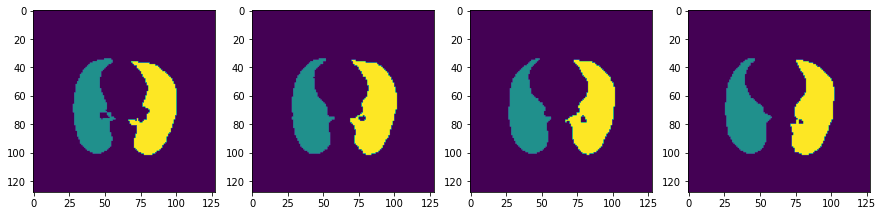

In [ ]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(CT_1_DATA_LungMask_1[0][15+i,:,:])



# Extract The Lung only

In [ ]:
####################### extraxt the real part of lung 

def apply_lung_mask(ct_img_array, lung_mask):
    ct_lung_seg = ct_img_array.copy()
    ct_lung_seg[lung_mask == 0] = 0
    return ct_lung_seg

def ExtrctRealPart(CT_Images,CT_1_DATA_LungMask_1):

    for i in tqdm(range(len(CT_1_DATA_LungMask_1))): 
            CT_1_DATA_LungMask_1[i][CT_1_DATA_LungMask_1[i] != 0] = 1

    ##### reshape the mask data for equal size of real data 
    for i in range(len(CT_Images)):
        CT_Images[i]=reshpe_pic(CT_Images[i]) 

    patient_ct_lung_seg=[]
    for i in range(len(CT_1_DATA_LungMask_1)):
        patient_ct_lung_seg.append(apply_lung_mask(CT_Images[i], CT_1_DATA_LungMask_1[i]))
    return  patient_ct_lung_seg   

patient_ct_lung_seg = ExtrctRealPart(CT_Images,CT_1_DATA_LungMask_1)



100%|██████████| 2/2 [00:00<00:00, 1155.77it/s]


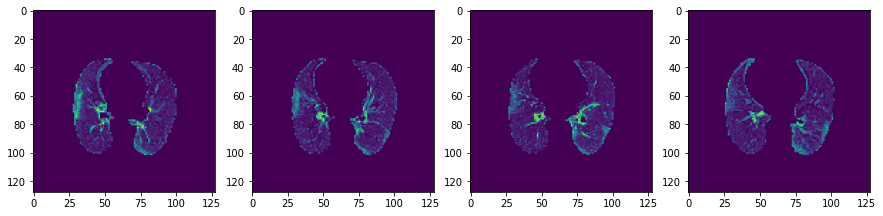

In [ ]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(patient_ct_lung_seg[0][15+i,:,:])


# Extract CT Masks


In [ ]:
#################  
Mask_1_DATA=[1]*len(common_list)
for i in range(len(common_list)):
    for j in range(len(normal_scan_paths_masks)):
            if(common_list[i] == normal_scan_paths_masks[j][68:]):
                 Mask_1_DATA[i] = normal_scan_paths_masks[j] 

###########
Mask_Images = [process_scan_mask(path) for path in tqdm(Mask_1_DATA)]

##### reshape the mask data for equal size of real data 
for i in range(len(Mask_Images)):
    Mask_Images[i]=reshpe_pic(Mask_Images[i]) 




100%|██████████| 2/2 [00:11<00:00,  5.71s/it]


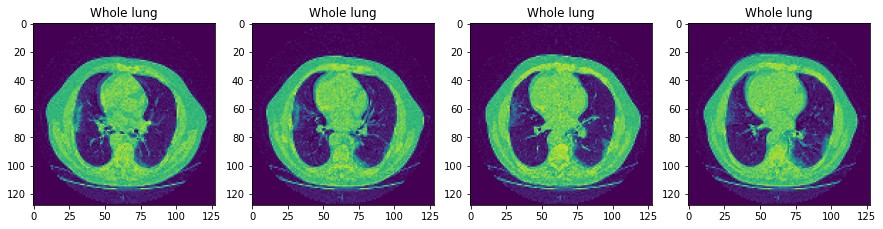

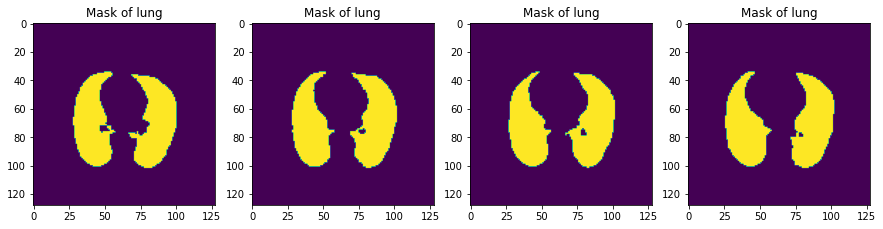

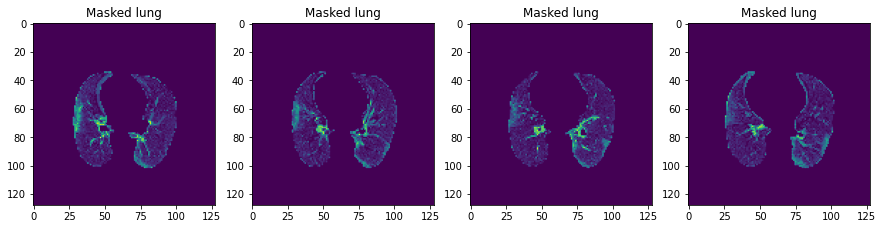

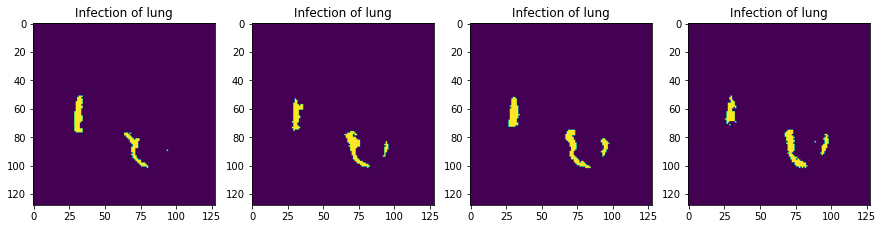

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(CT_Images[0][15+i,:,:])
    plt.title('Whole lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(CT_1_DATA_LungMask_1[0][15+i,:,:])
    plt.title('Mask of lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(patient_ct_lung_seg[0][15+i,:,:])    
    plt.title('Masked lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(Mask_Images[0][15+i,:,:])
    plt.title('Infection of lung')


#Cropping Process

In [ ]:

########### remove rezo slices 
import nibabel as nib
from skimage.transform import resize
from scipy import ndimage
from tqdm import tqdm
import pickle

################################ Remove Zero Slices of each Case 
def RemoveZeroSlices(CT_CuttedLung_Image_1,Mask_Images,LungMasks,CT_Images):
    for i in range(CT_CuttedLung_Image_1.shape[0]):
        if(CT_CuttedLung_Image_1[i,:,:].sum()!=0):
            start= i 
            break

    ##### find final slice 
    for i in range(CT_CuttedLung_Image_1.shape[0]):
        # print(i)
        if(CT_CuttedLung_Image_1[(CT_CuttedLung_Image_1.shape[0])-i-1,:,:].sum()!=0):
            stop = CT_CuttedLung_Image_1.shape[0]-i-1 
            break
    print("start:",start,"stop:",stop)
    return CT_CuttedLung_Image_1[start:stop,:,:], Mask_Images[start:stop,:,:], LungMasks[start:stop,:,:], CT_Images[start:stop,:,:]


################################ Define optimal border of a 2D slice
def SliceCrop(test_slice):
        ################################## Up 
        UpperRow=0
        for i in range(test_slice.shape[0]):
        ##### UpperRow
            if(test_slice[i,:].sum()!=0):
                UpperRow= i 
                break

        ################################## down
        LowerRow=0
        for i in range(test_slice.shape[0]):
            if(test_slice[(test_slice.shape[0])-i-1,:].sum()!=0):
                LowerRow= test_slice.shape[0]-i-1 
                break

        ################################## left
        LeftCol=0
        for i in range(test_slice.shape[1]):
        ##### LeftCol
            if(test_slice[:,i].sum()!=0):
                LeftCol= i 
                break

        ################################## Right
        RightCol=0
        for i in range(test_slice.shape[1]):
            if(test_slice[:,(test_slice.shape[1])-i-1].sum()!=0):
                RightCol= test_slice.shape[1]-i-1 
                break
        # print("UpperRow:",UpperRow,"LowerRow:",LowerRow,"LeftCol:",LeftCol,"RightCol:",RightCol)
        return UpperRow,LowerRow,LeftCol,RightCol




 ########## for all slices exract optimal size 
def BorderMaxSlices(CT_CuttedLung_Image_1):
    UpperRow=0
    LowerRow=0
    LeftCol=0
    RightCol=0

    MaxUpperRow=128
    MaxLowerRow=0
    MaxLeftCol=128
    MaxRightCol=0
    for i in range(CT_CuttedLung_Image_1.shape[0]):
            UpperRow,LowerRow,LeftCol,RightCol=SliceCrop(CT_CuttedLung_Image_1[i,:,:])
            # print("LeftCol:",LeftCol)
            if(MaxUpperRow>UpperRow): MaxUpperRow=UpperRow
            if(MaxLowerRow<LowerRow): MaxLowerRow=LowerRow
            if(MaxLeftCol>LeftCol): MaxLeftCol=LeftCol
            if(MaxRightCol<RightCol): MaxRightCol=RightCol
    return    MaxUpperRow,MaxLowerRow,MaxLeftCol,MaxRightCol

############## save the output data 
def SaveData(Images,Masks,DirImages,DirMasks):
    ###### Cropped Images
    with open(DirImages+'.pickle', 'wb') as handle:
        pickle.dump(Images, handle, protocol=pickle.HIGHEST_PROTOCOL)

    ##### Cropped Masks 
    with open(DirMasks+'.pickle', 'wb') as handle:
        pickle.dump(Masks, handle, protocol=pickle.HIGHEST_PROTOCOL)


######### final main function 
def MainCropping(CT_CuttedLung_Images,Mask_Images,LungMasks,CT_Images):
    ResiezedCTImages = []
    ResiezedMasks = []
    ResiezedLungMasks = []
    ResiezedBaseImage = []
    for i in tqdm(range(len(CT_CuttedLung_Images))):
            ########### Remove rezo slices 
            Image, Mask, LungMask, BaseImage = RemoveZeroSlices(CT_CuttedLung_Images[i],Mask_Images[i],LungMasks[i],CT_Images[i])

            ########## Define max size of each Case 
            UpperRow,LowerRow,LeftCol,RightCol=BorderMaxSlices(Image)

            ######## Cutting the all slices based on new border 
            Image = Image[:,UpperRow:LowerRow,LeftCol:RightCol]
            Mask = Mask[:,UpperRow:LowerRow,LeftCol:RightCol]
            LungMask = LungMask[:,UpperRow:LowerRow,LeftCol:RightCol]
            BaseImage = BaseImage[:,UpperRow:LowerRow,LeftCol:RightCol]

            ####### Resize the images 
            ResiezedCTImages.append( resize(Image, (32,128,128),anti_aliasing=True , order=5,mode='constant'))

            ####### Resize the Masks 
            ResiezedMasks.append( resize(Mask, (32,128,128),anti_aliasing=True , order=5,mode='constant'))

            ####### Resize the LungMasks 
            ResiezedLungMasks.append( resize(LungMask, (32,128,128),anti_aliasing=True , order=5,mode='constant'))

            ####### Resize the LungMasks 
            ResiezedBaseImage.append( resize(BaseImage, (32,128,128),anti_aliasing=True , order=5,mode='constant'))

    return ResiezedCTImages, ResiezedMasks, ResiezedLungMasks, ResiezedBaseImage
 

######### cropping process 
Images,Masks,LungMasks, BaseImage = MainCropping(patient_ct_lung_seg,Mask_Images,CT_1_DATA_LungMask_1,CT_Images)



  0%|          | 0/2 [00:00<?, ?it/s]

start: 1 stop: 31


 50%|█████     | 1/2 [00:02<00:02,  2.25s/it]

start: 3 stop: 29


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


# Plot Cropped Imges 

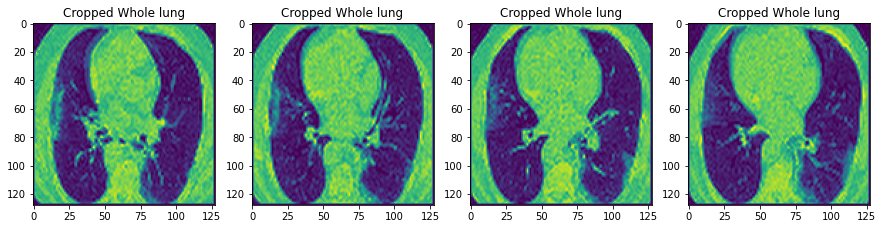

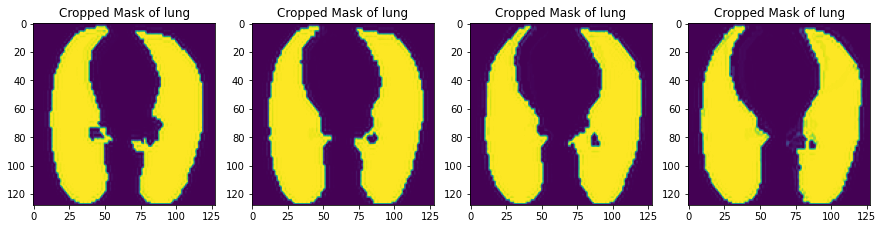

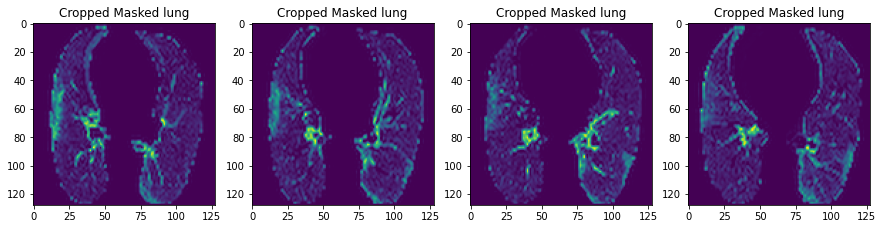

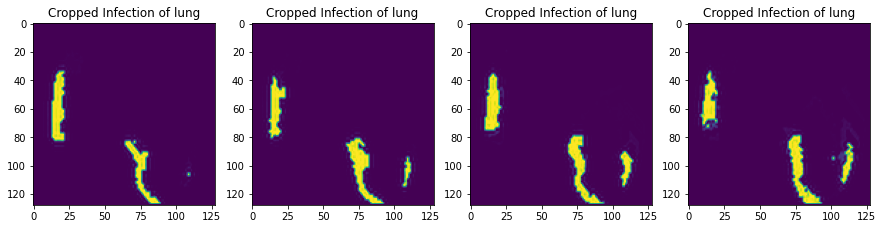

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(BaseImage[0][15+i,:,:])
    plt.title('Cropped Whole lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(LungMasks[0][15+i,:,:])
    plt.title('Cropped Mask of lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(Images[0][15+i,:,:])    
    plt.title('Cropped Masked lung')

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1,4,(i+1))
    plt.imshow(Masks[0][15+i,:,:])
    plt.title('Cropped Infection of lung')


# Save The Data

In [ ]:
def ConvListToNp(Images):
    Images_1 = np.zeros((len(Images),32,128,128))
    for i in range(len(Images)): 
        Images_1[i,:,:,:] = Images[i]
    return Images_1


##### cutted data 
Images = ConvListToNp(Images)
np.save('.../Data/PreprocessedData/LungImages.npy',Images)


###### All masks
Masks = ConvListToNp(Masks)
np.save('.../Data/PreprocessedData/InfectionMasks.npy',Masks)


###### Lung Masks 
LungMasks = ConvListToNp(LungMasks)
np.save('.../Data/PreprocessedData/LungMask.npy',LungMasks)


####### Base CT images 
BaseImage = ConvListToNp(BaseImage)
np.save('.../Data/PreprocessedData/BaseCTImages.npy',LungMasks)


In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl